# Исследование и приоритезация продуктовых гипотез

В нашем распоряжении данные о 9 гипотезах для увеличения выручки. Нам предстоит приоритизировать гипотезы, запустить A/B тест и проанализировать результаты.

## Предварительный анализ данных

**Описание данных:**

Файл *hypothesis.csv*

**Hypothesis** — краткое описание гипотезы; <br>
**Reach** — охват пользователей по 10-балльной шкале;<br>
**Impact** — влияние на пользователей по 10-балльной шкале;<br>
**Confidence** — уверенность в гипотезе по 10-балльной шкале;<br>
**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл *orders.csv*

**transactionId** — идентификатор заказа;<br>
**visitorId** — идентификатор пользователя, совершившего заказ;<br>
**date** — дата, когда был совершён заказ;<br>
**revenue** — выручка заказа;<br>
**group** — группа A/B-теста, в которую попал заказ.

Файл *visitors.csv*

**date** — дата;<br>
**group** — группа A/B-теста;<br>
**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
pd.set_option('display.max_columns', None)

In [2]:
# Выгрузка данных
try:
    hyp, orders, visitors = (
        pd.read_csv('D:/Practicum/Аналитика данных/Принятие решений в бизнесе/Проект/hypothesis.csv'), # посещения
        pd.read_csv('D:/Practicum/Аналитика данных/Принятие решений в бизнесе/Проект/orders.csv'), # покупки
        pd.read_csv('D:/Practicum/Аналитика данных/Принятие решений в бизнесе/Проект/visitors.csv') # рекламные расходы
    )
except:
    hyp, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    )

In [3]:
# Просмотр информации о данных и поиск возможных явных дубликатов
for table in [hyp, orders, visitors]:
    display(table.head())
    display(table.info())
    print(f'Количество пропусков: {table.isna().sum()}')
    print(table.duplicated().sum())
    print('-' * 60)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Количество пропусков: Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
0
------------------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Количество пропусков: transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0
------------------------------------------------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Количество пропусков: date        0
group       0
visitors    0
dtype: int64
0
------------------------------------------------------------


Пропусков в данных нет, однако есть места, где нужно навести порядок:
1. названия столбцов не приведены к snake case
2. данные о времени имеют некорректный тип даннных


## Предобработка данных

Приведем названия столбцов к snake case, а также данные о времени к соответствующему типу.

In [4]:
# Приведение названий столбцов к snake_case
orders.columns = [letter.replace('Id', '_id') for letter in orders.columns.values]
hyp.columns = [letter.lower() for letter in hyp.columns.values]

In [5]:
# преобразование типов данных в столбцах со временем
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Данные приведены в порядок и готовы к дальнейшему анализу.

## Приоритезация гипотез

### Применение фреймворка ICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [6]:
# Посчитаем ICE для гипотез
hyp['ICE'] = ( hyp['impact'] * hyp['confidence']) / hyp['efforts']
display(hyp[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(2))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


Пятерка лидеров гипотез после применения ICE по убыванию приоритета: 8, 0, 7, 6, 2

### Применение фреймворка RICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

In [7]:
# Посчитаем RICE для гипотез
hyp['RICE'] = (hyp['reach'] *  hyp['impact'] * hyp['confidence']) / hyp['efforts']
display(hyp[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).round(2))

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Пятерка лидеров гипотез после применения RICE по убыванию приоритета: 7, 2, 0, 6, 8

**Выводы:** Как мы видим в пятерке лучших одни и те же гипотезы (0, 2, 6, 7, 8), однако приоритетность у двух методов оценки разная. У ICE и RICE разные формулы, отличающиеся одним параметром - охватом аудитории. Соответственно если охват аудитории при примении RICE большой, то приотет гипотезы становится значительно выше. Так, например, гипотеза 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) опережает по значимости следующую аж в 2 раза. Параметр охвата (Reach), использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE.

## Анализ A/B-теста

Мы провели парный A/B-тест в течение авгута 2019 г. и получили результаты, которые описаны в файлах ab-orders.csv и ab-visitors.csv. <br>
Проанализируем A/B-тест. Для начала посмотрим как распределилось количество заказов по группам.

In [8]:
orders.groupby('group')['transaction_id'].count()

group
A    557
B    640
Name: transaction_id, dtype: int64

Далее проверим, существуют ли пользователи, которые попали сразу в обе группы

In [9]:
duplicated_users = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
display(duplicated_users.head())
len(duplicated_users.query('group > 1'))

,visitor_id,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


58

58 пользователей попали в обе группы. Непонятно, какая из версий повлияла на склонность к покупке пользователя. Поэтому, чтобы можно было однозначно определить результаты исследования, следует исключить этих пользователей.

In [10]:
# исключаем пользователей, попавших в обе группы
delete_list = list(duplicated_users[duplicated_users.group > 1]['visitor_id'])
orders = orders.query('visitor_id not in @delete_list')
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [11]:
# проверяем, что не осталось пользователей, попавких в обе группы
duplicated_users = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
len(duplicated_users.query('group > 1'))

0

Посмотрим распределение по группам после удаления пользователей, попавших в обе группы.

In [12]:
orders.groupby('group')['transaction_id'].count()

group
A    468
B    548
Name: transaction_id, dtype: int64

Группы теста делятся не 50 на 50, а 46 на 54, относительное различие количества будет равно (1 - 46/54 = 14.8) - почти 15%. Разные доли искажают результаты, необходимо принять этото факт во внимание.

### Кумулятивная выручка

In [13]:
#Создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

#Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transaction_id' : pd.Series.nunique, 
                                          'visitor_id' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

#Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#Объединим кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

#Переименуем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


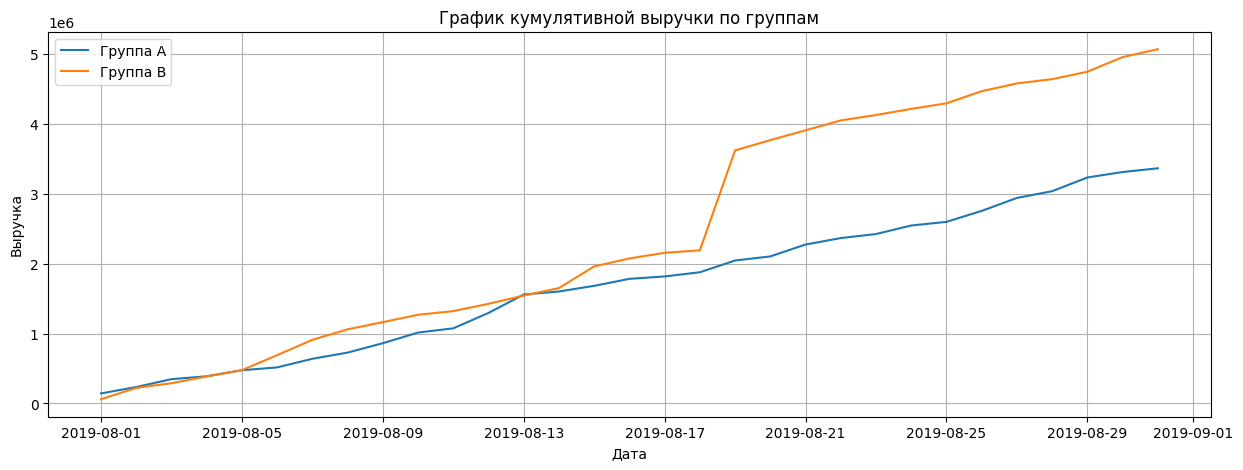

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend()
plt.show()

В обеих группах выручка увеличивается на протяжении всего теста, однако виден резкий скачок в графике у группы B. Возможно было проведено аномально большое количество заказов или неестественно крупный чек, что также говорит об аномалии.

### Кумулятивный средний чек

Чтобы найти средний кумулятивный чек по группам — нужно разделить кумулятивную выручку на кумулятивное число заказов.

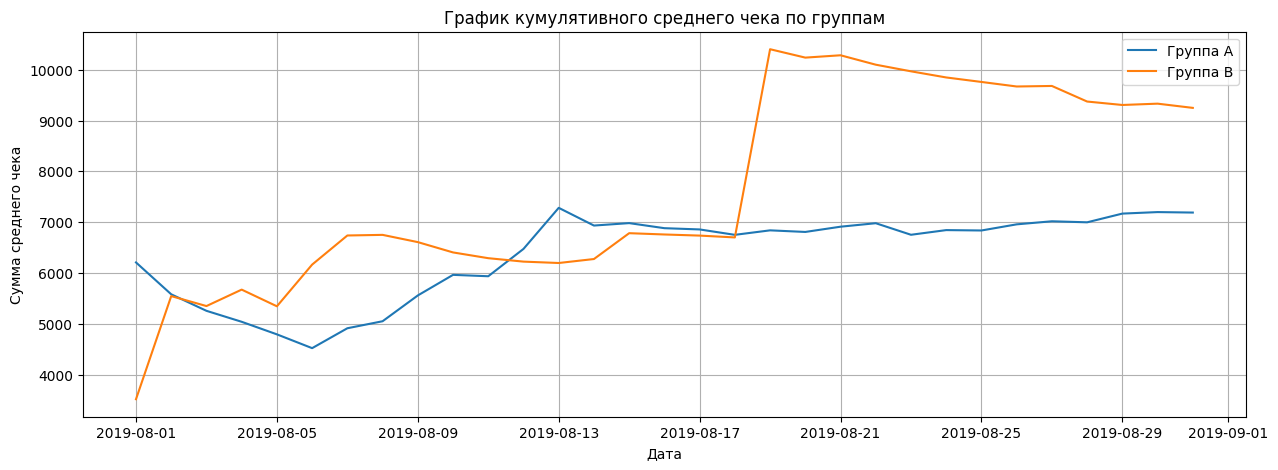

In [15]:
plt.figure(figsize=(15,5))

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.grid()
plt.legend()
plt.show()

Средний чек в группе A за первые две недели подрос и стабилизировался, а в группе B резко подскочил и стал постепенно снижаться. Возможно имеются аномальные значения, которые искажают общую картину группы B.

### Относительное изменение кумулятивного среднего чека группы B к группе A.

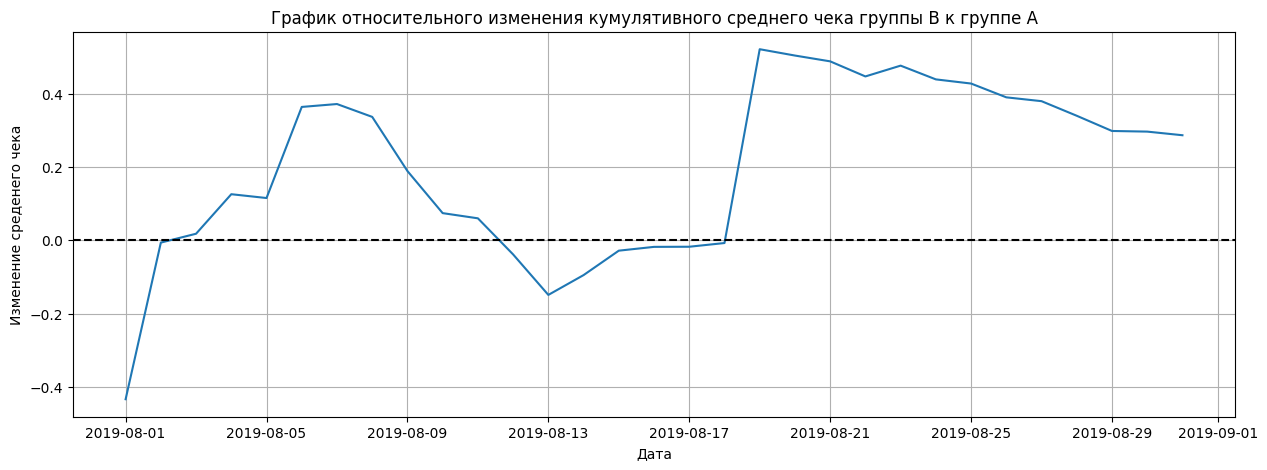

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date',\
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])\
         / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение среденего чека')
plt.grid()
# добавляем ось X
plt.axhline(y = 0, color = 'black', linestyle = '--') ;
plt.show()

Колебания очень резкие, необходимо проверить данные на наличие аномальных заказов  и пользователей.

### Кумулятивное среднее количество заказов на посетителя

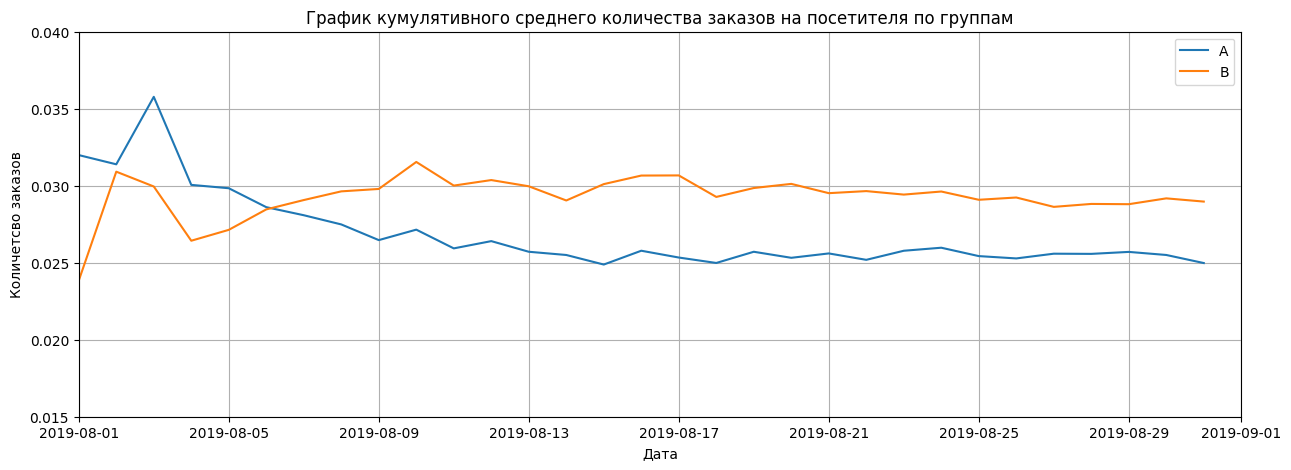

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Количетсво заказов')
plt.grid()
# масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.015, 0.04])
plt.show()

Сначала среднее количество заказов на посетителя группы A было выше, чем у B, однако со временем  показатели стабилизировались и у B осталось преимущество.

### Относительное изменение среднего количества заказов на посетителя группы B к группе A


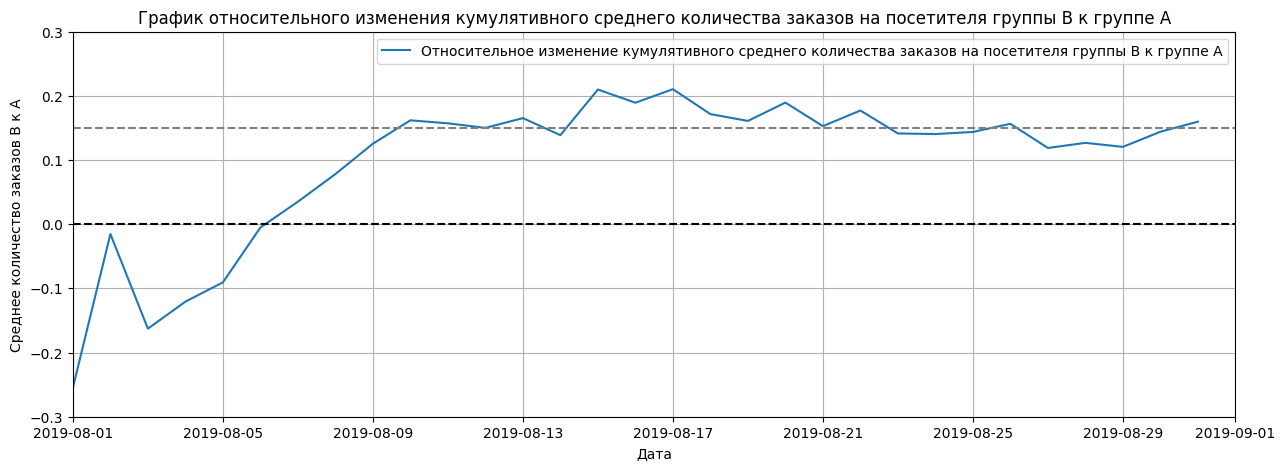

In [18]:
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])
                              )
plt.figure(figsize = (15,5))
plt.plot(mergedCumulativeConversions['date'], \
     mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1, \
     label = "Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A")

plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.15, color = 'grey', linestyle = '--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Cреднее количество заказов B к A')
plt.grid()
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.3])
plt.show()

 В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом прирост среднего количества заказов группы B стабилизировался в районе +15% относительно группы A.

### Распределние заказов по пользователям

Построим точечный график количества заказов по пользователям.

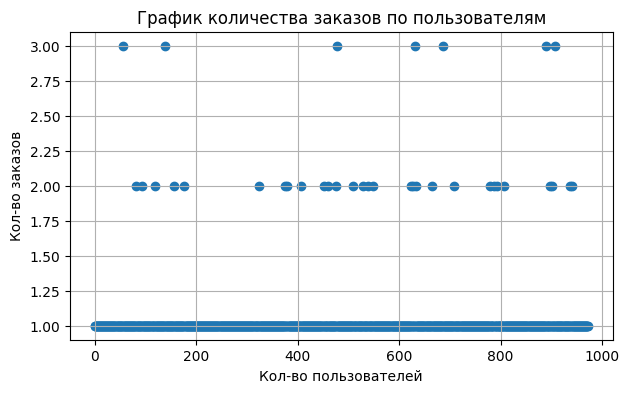

In [19]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index = False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize = (7,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Кол-во заказов')
plt.grid()


Абсолютное большинство пользователей совершают один заказ, заказавших дважды значительно меньше, а трижды совсем единицы.

Выберем границу для определения аномальных пользователей. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [20]:
# находим перцентили 95 и 99.
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


95% пользователей совершают не больше 1 заказа, 99% совершают не более 2 заказов, отсеим 1% наблюдений с крайними значениями, это и есть аномалии.

### Распределение стоимостей заказов

Построим точечный график стоимостей заказов.

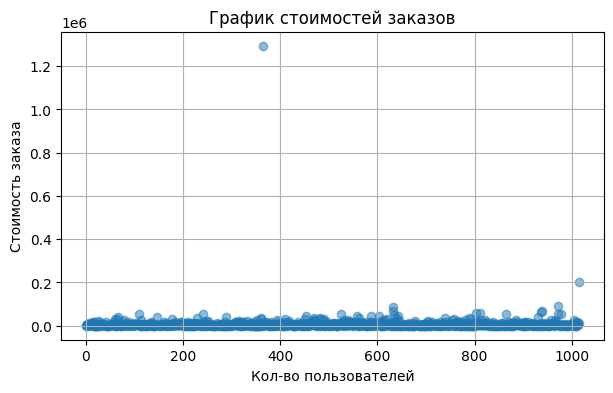

In [21]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize = (7,4))
plt.scatter(x_values, orders['revenue'], alpha = 0.5)
plt.title('График стоимостей заказов')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа')
plt.grid()

Один из заказов явно выделяется среди остальных. В то время как большинство колеблется в районе 50 000, этот больше 1 200 000.

(0.0, 210000.0)

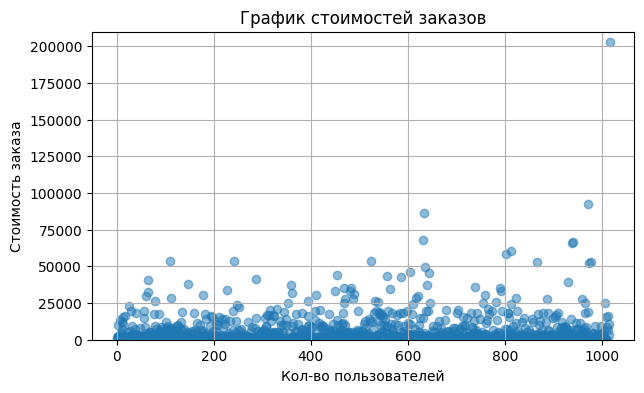

In [22]:
# уменьшим лимит по оси y чтобы поточнее посмотреть распределение заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize = (7,4))
plt.scatter(x_values, orders['revenue'], alpha = 0.5)
plt.title('График стоимостей заказов')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.ylim([0, 210000])

Большинство покупателей тратят не более 25 000. Насколько много остальных заказов узнаем с помощью перцентилей.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [23]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Получается, что у 5 % сумма заказов больше 26785₽, а у 1% свыше 53904₽. За границу для определения аномальных заказов примем значение 53904₽, то есть войдут 99% всех заказов.

## Статистический анализ

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по "сырым" данным.

Подготовим "сырые" данные. Соберем в общую таблицу все данные по заказам и визитам и добавим кумулятивные показатели.

In [24]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [25]:
ordersADaily = (orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: 
        ordersADaily[ordersADaily['date'] <= x['date']]
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [26]:
ordersBDaily = (orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: 
        ordersBDaily[ordersBDaily['date'] <= x['date']]
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [27]:
data = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))
display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Теперь можно посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [28]:
ordersByUsersA = (orders[orders['group']=='A']
                  .groupby('visitor_id', as_index=False)
                  .agg({'transaction_id' : pd.Series.nunique}))
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (orders[orders['group']=='B']
                  .groupby('visitor_id', as_index=False)
                  .agg({'transaction_id' : pd.Series.nunique}))
ordersByUsersB.columns = ['user_id', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.
Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке. Выберем критерий Манна-Уитни, так как все наблюдения обеих групп независимы друг от друга, пользователи в различных группах, формы распределений для двух групп примерно одинаковы(распределение не нормальное, то есть алгебраические метрики работают плохо).

In [29]:
sampleA = pd.concat([ordersByUsersA['orders'], \
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                     name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], \
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                     name='orders')],axis=0)

Сформулируем гипотезы:
- **H0:** статистически значимых различий в среднем количестве заказов на посетителя между группами нет
- **H1:** статистически значимые различия в среднем количестве заказов на посетителя между группами есть

In [30]:
alpha = .05 
results = st.mannwhitneyu(sampleA, sampleB)

print('p-значение: ', '{0:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Относительный выигрыш группы B:', '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.011
Отвергаем нулевую гипотезу
Относительный выигрыш группы B: 0.160


Нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет отвергаем, по "сырым" данным различия между группами A и B есть. Также видно, что относительный выигрыш группы B равен 16%

### Статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы:
- **H0:** статистически значимых различий в среднем чеке между группами нет
- **H1:** статистически значимые различия в среднем чеке между группами есть

In [31]:
alpha = .05 
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-значение: ', '{0:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
print('Отношение среднего чека группы B к среднему чеку группы A:', '{0:.3f}'
       .format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу
Отношение среднего чека группы B к среднему чеку группы A: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Также видно, что средний чек группы B значительно выше среднего чека группы A, почти на 29%.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным.

Подготовим данные, убирем аномалии. <br>
В предыдущих расчётах мы приняли за аномальных пользователей тех, кто:

- совершил 3 и больше заказов (1%)
- совершил заказ дороже 53904 рублей(1%)

In [32]:
# пользователи с заказами 3 и более(тот самый аномальный 1%)
usersWithManyOrders = (
    pd.concat([ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['user_id'],
               ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['user_id']],
              axis = 0))
# пользователи с суммой заказов более 53904(тот самый аномальный 1%)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
# объединяем пользователей аномальных как по кол-ву заказов, так и по сумме
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head())
print('Всего аномальных пользователей:', abnormalUsers.shape[0])
print('Аномальные пользователи относительно всех:', round(abnormalUsers.shape[0] / orders['visitor_id'].nunique(), 3))

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

Всего аномальных пользователей: 16
Аномальные пользователи относительно всех: 0.016


Всего 16 аномальных пользователей, что составляет всего порядка 1.5% от общего количества - не так много. Узнаем, как их действия повлияли на результаты теста.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами теста по очищенным данным без аномалий.

In [33]:
# убираем аномальных пользователей
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                             name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                             name='orders')],axis=0) 

Сформулируем гипотезы:
- **H0:** статистически значимых различий в среднем количестве заказов на посетителя между группами нет
- **H1:** статистически значимые различия в среднем количестве заказов на посетителя между группами есть

In [34]:
alpha = .05 
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)

print('p-значение: ', '{0:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Относительный выигрыш группы B:', '{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение:  0.007
Отвергаем нулевую гипотезу
Относительный выигрыш группы B: 0.189


Нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет отвергаем, по "очищенным" данным различия между группами A и B есть. Также видно, что относительный выигрыш группы B равен практически 19%, что на 3% больше чем в "сырых".

### Статистическую значимость различий в среднем чеке заказа между группами по "очищенным" данным.

Сформулируем гипотезы:
- **H0:** статистически значимых различий в среднем чеке между группами нет
- **H1:** статистически значимые различия в среднем чеке между группами есть

In [35]:
alpha = .05
results = st.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])

print('p-value: ', "{0:.3f}".format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('отношение среднего чека группы B к среднему чеку группы A:',
    "{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() /
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value:  0.788
Не получилось отвергнуть нулевую гипотезу
отношение среднего чека группы B к среднему чеку группы A: -0.032


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако средний чек группы B оказался ниже на 3% чем группы A, хотя по "сырым" данным он был выше на 29%. Слишком дорогие заказы(аномально крупные) значительно повлияли на результаты A/B-теста.

## Итоги

После проведения A/B-теста есть три варианта решений:

1. Остановить тест, зафиксировать победу одной из групп
2. Остановить тест, зафиксировать отсутствие различий между группами
3. Продолжить тест

В целом тест можно остановить: средние чеки групп примерно одинаковые, а конверсия группы B на 19% выше, чем у группы A, причем конверсия стабилизоровалась, нет каких-то непонятных скачков. Основываясь на результатах теста фиксируем **победу группы B.**